Authors: Nicolas Legrand <nicolas.legrand@cfin.au.dk>

In [1]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from metadPy import dprime, criterion

# Generate reports and clean data

The individual reports and the data transfer were generated using the following scripts: `reports_HRD.py` and `reports_HBC.py` for the Heart rate Discrimination task and the Heartbeat Counting task respectively. This requires access to the raw data that are not provided in this repository due to their size. Therefore the scripts will not run but are provided for information.

# Merge subject level dataframe

All behavioural results are concatenated into a single data frame for each session, returning `Del1_merged.txt` and `Del2_merged.txt`. The participants that should be rejected based on their reports are removed here.

# Session 1 

In [2]:
datapath = os.path.join(
    os.path.abspath(os.path.join(os.getcwd(), os.pardir)),
    'data', 'raw', 'HRD')

outputpath = os.path.join(
    os.path.abspath(os.path.join(os.getcwd(), os.pardir)),
    'data')
session = 'Del1'
subjects = os.listdir(datapath)

After checking the individual reports manually, it was decided to remove the following participants from the group analysis.

In [3]:
remove = ['sub_0036', 'sub_0041', 'sub_0054', 'sub_0067', 'sub_0069', 'sub_0078', 'sub_0084', 'sub_0086', 'sub_0139', 'sub_0143', 'sub_0173', 'sub_0234']

In [4]:
merged_df = pd.DataFrame([])  # Concatenated raw data
for sub in subjects:
    df = pd.read_csv(os.path.join(datapath, sub, 'filtered.txt'))
    df["Subject"] = sub
    df = df.rename(columns={'Estimation': 'Descision', 'EstimationRT': 'DecisionRT'})
    merged_df = merged_df.append(df, ignore_index=True)

# Remove particpants
for sub_rm in remove:
    merged_df = merged_df[merged_df.Subject != sub_rm]

# Save data frame
merged_df.to_csv(
    os.path.join(
        outputpath, 'Del1_merged.txt'),
    index=False)

In [5]:
print(f'{merged_df.Subject.nunique()} participants remaining in Session 1')

206 participants remaining in Session 1


# Session 2

In [6]:
datapath = os.path.join(
    os.path.abspath(os.path.join(os.getcwd(), os.pardir)),
    'data', 'raw', 'HRD2')

outputpath = os.path.join(
    os.path.abspath(os.path.join(os.getcwd(), os.pardir)),
    'data')
session = 'Del2'
subjects = os.listdir(datapath)

After checking the individual reports manually, it was decided to remove the following participants from the group analysis.

In [7]:
remove = ['sub_0139']

In [8]:
merged_df = pd.DataFrame([])  # Concatenated raw data
for sub in subjects:
    df = pd.read_csv(os.path.join(datapath, sub, 'filtered.txt'))
    df["Subject"] = sub
    merged_df = merged_df.append(df, ignore_index=True)

# Remove particpants
for sub_rm in remove:
    merged_df = merged_df[merged_df.Subject != sub_rm]

# Save data frame
merged_df.to_csv(
    os.path.join(
        outputpath, 'Del2_merged.txt'),
    index=False)

In [9]:
print(f'{merged_df.Subject.nunique()} participants remaining in Session 2')

191 participants remaining in Session 2


# Summary dataframe

Here, the raw data are summarized for each session, modality and participant separately and stored in a unique `behavior.txt` file for the two sessions. The Psi estimates and the incomplete convergence index are computed here.

In [10]:
def reversals(df):
    d = np.diff(df.Alpha.to_numpy())
    reversals = d[:-1] != d[1:]
    return np.median(df.Alpha.to_numpy()[1:-1][reversals])

In [11]:
behavior_df = pd.DataFrame([])

for session in ['Del1', 'Del2']:

    group_df = pd.read_csv(
        os.path.join(outputpath, f'{session}_merged.txt'))
 
    for sub in group_df['Subject'].unique():

        taskDuration = (
            group_df.loc[group_df.Subject == sub, "StartListening"].to_numpy()[-1] -
                group_df.loc[group_df.Subject == sub, "StartListening"].to_numpy()[0]
            ) / 60

        for modality in ["Intero", "Extero"]:
            
            threshold, slope, decisionRT, confidenceRT, accuracy, confidence,\
                threshold_updown = None, None, None, None, None, None, None
            
            this_df = group_df[(group_df.Subject == sub) & (group_df.Modality == modality)]

            threshold, slope = (
                this_df[~this_df.EstimatedThreshold.isnull()].EstimatedThreshold.iloc[-1],
                this_df[~this_df.EstimatedSlope.isnull()].EstimatedSlope.iloc[-1],
            )
            decisionRT, confidenceRT = (
                this_df["DecisionRT"].median(),
                this_df.ConfidenceRT.median(),
            )
            accuracy, confidence = (
                this_df["ResponseCorrect"].mean() * 100,
                this_df["Confidence"].mean(),
            )

            # Threshold from up/down staircase
            threshold_updown = np.mean([
                reversals(this_df[this_df.StairCond=='low']),
                reversals(this_df[this_df.StairCond=='high'])
            ])

            # Ratio of staircase corruption
            ratio = ((this_df.Alpha - this_df.EstimatedThreshold).loc[-40:] > 0).mean()
            corruption_ratio = np.abs(ratio-0.5)*2

            behavior_df = behavior_df.append(
                {
                    "Subject": sub,
                    "Session": session,
                    "Modality": modality,
                    "Accuracy": accuracy,
                    "Confidence": confidence,
                    "Threshold": threshold,
                    "Threshold_UpDown": threshold_updown,
                    "Slope": slope,
                    "TaskDuration": taskDuration,
                    "DecisionRT": decisionRT,
                    "ConfidenceRT": confidenceRT,
                    "Corruption": corruption_ratio,
                },
                ignore_index=True,
            )

# Save data frame
behavior_df.to_csv(
    os.path.join(
        outputpath, 'behavior.txt'),
    index=False)

C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


## Descriptive statistics

In [12]:
behavior_df = pd.read_csv(os.path.join(outputpath, 'behavior.txt'))

In [13]:
print(f'Number of participants: {len(behavior_df.Subject.unique())}')
del1 = len(behavior_df[behavior_df.Session=='Del1'].Subject.unique())
print(f'Del 1: {del1}')
del2 = len(behavior_df[behavior_df.Session=='Del2'].Subject.unique())
print(f'Del 1: {del2}')

Number of participants: 218
Del 1: 206
Del 1: 191


## Task duration

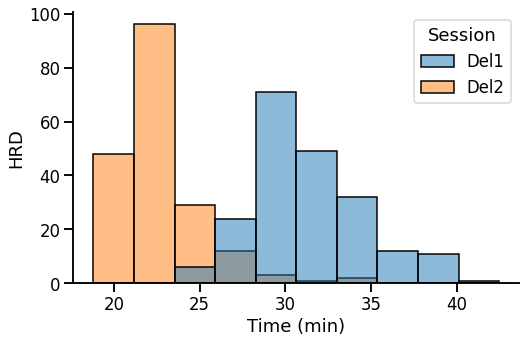

In [14]:
sns.set_context('talk')
plt.figure(figsize=(8, 5))
sns.histplot(data=behavior_df[behavior_df.Modality=='Intero'],
             x='TaskDuration', hue='Session')
plt.xlabel('Time (min)')
plt.ylabel('HRD')
sns.despine()

In [15]:
for session in ['Del1', 'Del2']:
    print(f'Session: {session} - Task mean time: {round(behavior_df[behavior_df.Session == session].TaskDuration.mean(), 2)} min')
    print(f'Session: {session} - Task std time: {round(behavior_df[behavior_df.Session == session].TaskDuration.std(), 2)} min')
    print(f'Session: {session} - Task max time: {round(behavior_df[behavior_df.Session == session].TaskDuration.max(), 2)} min')
    print(f'Session: {session} - Task min time: {round(behavior_df[behavior_df.Session == session].TaskDuration.min(), 2)} min')

Session: Del1 - Task mean time: 31.33 min
Session: Del1 - Task std time: 3.32 min
Session: Del1 - Task max time: 42.46 min
Session: Del1 - Task min time: 24.27 min
Session: Del2 - Task mean time: 22.67 min
Session: Del2 - Task std time: 2.44 min
Session: Del2 - Task max time: 33.81 min
Session: Del2 - Task min time: 18.81 min


## Psi convergence index

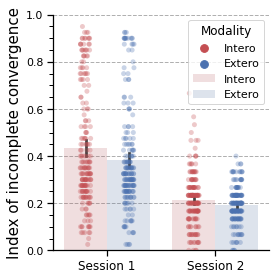

In [16]:
sns.set_context('notebook')
fig, ax = plt.subplots(1, 1, figsize=(4, 4), sharey='row')

sns.stripplot(data=behavior_df, x='Session', y='Corruption', hue='Modality', dodge=1, edgecolors='k', palette=['#c44e52', '#4c72b0'], linewidths=1, alpha=0.3, ax=ax)
sns.barplot(data=behavior_df, x='Session', y='Corruption', hue='Modality', alpha=0.2, palette=['#c44e52', '#4c72b0'], ax=ax)

plt.xticks([0, 1], ['Session 1', 'Session 2'], size=12)
plt.xlabel('')
ax.minorticks_on()
ax.set_axisbelow(True)
ax.grid(which='major', axis='y',linestyle='--')
ax.tick_params(axis='x', which='minor', bottom=False)
ax.set_ylabel('Index of incomplete convergence', size=15)
ax.set_ylim([0, 1])
plt.tight_layout()
sns.despine()
plt.savefig(os.path.abspath(os.path.join(os.getcwd(), os.pardir)) + f'/figures/SupplementaryMaterial2Stripplot.svg', dpi=300)

In [17]:
intero = (behavior_df[(behavior_df.Session=='Del1') & (behavior_df.Modality=='Intero')].Corruption > 0.5).sum()
extero = (behavior_df[(behavior_df.Session=='Del1') & (behavior_df.Modality=='Extero')].Corruption > 0.5).sum()
print(f'Session 1: Intero: {intero} and Extero: {extero} staircases with a high incomplete convergence index.')

Session 1: Intero: 63 and Extero: 41 staircases with a high incomplete convergence index.


In [18]:
intero = (behavior_df[(behavior_df.Session=='Del2') & (behavior_df.Modality=='Intero')].Corruption > 0.5).sum()
extero = (behavior_df[(behavior_df.Session=='Del2') & (behavior_df.Modality=='Extero')].Corruption > 0.5).sum()
print(f'Session 2: Intero: {intero} and Extero: {extero} staircases with a high incomplete convergence index.')

Session 2: Intero: 3 and Extero: 0 staircases with a high incomplete convergence index.


## Demographics

In [19]:
dates_df = pd.read_csv(os.path.join(outputpath, 'dates.csv'), sep=';')
dates_df['Subject'] = [f'sub_{str(id).zfill(4)}' for id in dates_df['record_id']]
dates_df = pd.merge(behavior_df, dates_df, on=['Subject'])

In [20]:
days_avg = dates_df[(dates_df.Session=='Del2') & (dates_df.Modality=='Intero')]['Diff in days'].mean()
days_std = dates_df[(dates_df.Session=='Del2') & (dates_df.Modality=='Intero')]['Diff in days'].std()
days_min = dates_df[(dates_df.Session=='Del2') & (dates_df.Modality=='Intero')]['Diff in days'].min()
days_max = dates_df[(dates_df.Session=='Del2') & (dates_df.Modality=='Intero')]['Diff in days'].max()
print(f'Average delay: {days_avg} - Min delays {days_min} - Max delays {days_max} - STD {days_std}')

Average delay: 46.79032258064516 - Min delays 10.0 - Max delays 97.0 - STD 23.87521870064204


In [21]:
demographics_df = pd.read_csv(os.path.join(outputpath, 'demographics.csv'), sep=',')

In [22]:
demographics_df = pd.read_csv(os.path.join(outputpath, 'demographics.csv'), sep=',')
demographics_df['Subject'] = [f'sub_{str(id).zfill(4)}' for id in demographics_df['record_id']]
demographics_df = pd.merge(demographics_df, behavior_df, on=['Subject'], how='right')

In [23]:
age_mean = demographics_df.groupby(['Subject']).mean().age.mean()
age_std = demographics_df.groupby(['Subject']).mean().age.std()
age_max = demographics_df.groupby(['Subject']).mean().age.max()
age_min = demographics_df.groupby(['Subject']).mean().age.min()

print(f'Average age: {age_mean} - Age std {age_std} - Age min {age_min} - Age max {age_max}')

Average age: 24.89908256880734 - Age std 5.3027163791550525 - Age min 18 - Age max 56


In [24]:
print(f" {len(demographics_df.groupby(['Subject']).mean())} participants - {(demographics_df.groupby(['Subject']).mean()['gender'] == 1).sum()} female, {(demographics_df.groupby(['Subject']).mean()['gender'] == 2).sum()} males, {(demographics_df.groupby(['Subject']).mean()['gender'] == 3).sum()} other")

 218 participants - 126 female, 91 males, 1 other
